# Final Project

The final project is designed to let you apply what you have learned so far, and demonstrate that you have mastered it. The submission will be graded on the correctness and performance of the execution of your analysis (50%), the ambitiousness of the problems chosen (30%), and the creativity of your questions and solutions (20%).

Your submission should include all outputs and be *self-contained*, so it can be executed if necessary.

The submission includes two parts:
1. this notebook
2. a 15-min presentation, to be held on May 8


## Submission
The project is due on ***May 07, 23:59 CET*** (counted as the time stamp when it is received). Late submissions will **not** be considered, and graded as 0! 

To submit, please:

1. copy this file and all additional data into a folder with your group ID
3. zip the folder
4. send a copy of the zip file to Dirk Hovy <dirk.hovy@unibocconi.it> and Tommaso Fornaciari <fornaciari@unibocconi.it>

## 1. Data, Preprocessing, and Annotation (4 pts)

Find a data set for text classification and a data set for structured prediction. These can be the same.
Kaggle is a good place to start, or the Google data set search. 

The data sets should have **at least 5,000** documents each. **At least 2000 instances** need to be labeled. If there is no label provided, you can annotate your own. You can get up to **3 bonus points** for annotation, depending on the amount and complexity of the annotation.

Split the data into dedicated training, development, and test sets (if they do not include these already)!

Briefly (max. 100 words!) describe the content and type of the data set, and what you are planning to look at. 

...

Preprocess the data and explain (max. 200 words) which preprocessing steps you chose and why, and give statistics of the number of documents, types, and tokens, before and after preprocessing.

...

In [56]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

data = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
data.head()

,article_link,headline,is_sarcastic
0,https://www.theonion.com/thirtysomething-scien...,thirtysomething scientists unveil doomsday clo...,1
1,https://www.huffingtonpost.com/entry/donna-edw...,dem rep. totally nails why congress is falling...,0
2,https://www.huffingtonpost.com/entry/eat-your-...,eat your veggies: 9 deliciously different recipes,0
3,https://local.theonion.com/inclement-weather-p...,inclement weather prevents liar from getting t...,1
4,https://www.theonion.com/mother-comes-pretty-c...,mother comes pretty close to using word 'strea...,1


In [57]:
nlp = spacy.load('en_core_web_sm')
def clean(text):
    return ' '.join([token.lemma_ 
             for token in nlp(text) 
             if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'X'}])

def verb(text):
    '''
    return the strings with the verbs only
    '''
    return ' '.join([token.lemma_ 
             for token in nlp(text) 
             if token.pos_ in {'VERB'}])

In [58]:
data['cleaned'] = data.headline.apply(clean)
data['verb'] = data.headline.apply(verb)

There are 28619 article headlines
Presence of NAN False
0    14985
1    13634
Name: is_sarcastic, dtype: int64


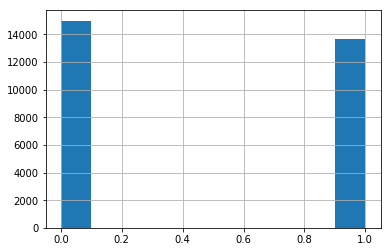

In [59]:
data.drop("article_link", axis = 1, inplace = True)

data['Set'] = np.random.choice(
    ['train', 'valid', 'test'],
    data.shape[0],
    p=[0.7, 0.15, 0.15]
)

print("There are", data.shape[0],'article headlines')
print("Presence of NAN" , data.isna().values.any())
print(data.is_sarcastic.value_counts())
data.is_sarcastic.hist()

In [60]:
data.to_csv('cleaned_data.csv')

In [61]:
data = pd.read_csv("cleaned_data.csv")

In [62]:
data.head()

,Unnamed: 0,headline,is_sarcastic,cleaned,verb,Set
0,0,thirtysomething scientists unveil doomsday clo...,1,thirtysomething scientist hair loss,NaN,valid
1,1,dem rep. totally nails why congress is falling...,0,totally nail why fall short gender racial equa...,nail fall,train
2,2,eat your veggies: 9 deliciously different recipes,0,eat veggie deliciously different recipe,eat,train
3,3,inclement weather prevents liar from getting t...,1,inclement weather prevent liar get work,prevent get work,train
4,4,mother comes pretty close to using word 'strea...,1,mother come pretty close use word streaming co...,come use,train


In [64]:
sarcasm = data.loc[data["is_sarcastic"] == 1,["headline","cleaned","verb"]]
normal = data.loc[data["is_sarcastic"] == 0,["headline","cleaned","verb"]]

## 2. Research Question(s) (2 pts)

Describe what question you are investigating with the data (max. 100 words)

...

## 3. Analysis (6 pts)

Apply at least one version of *each* of the following analysis methods to the data set (justify your choices):
1. Topic modeling with LDA (3 pts). Justify your choice of number of topics!
2. Dense word embeddings ***or*** document embeddings: visualize these and show a clustering (3 pts) 

Your analysis needs to be run on the training data only! You can use the dev set for tuning.

### Other methods
If appropriate for your problem, feel free to explore other methods, as long as they do not require additional libraries (**up to 2 bonus points**).

In [69]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                             min_df=0.01, #df stands for document frequency
                             max_df=0.6, 
                             stop_words='english')
X = tfidf_vectorizer.fit_transform(sarcasm.cleaned.dropna().tolist())

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word', min_df=0.01, max_df=0.6, stop_words='english')

X2 = vectorizer.fit_transform(sarcasm.cleaned.dropna().tolist())

df = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                       })
print("Sarcasm Words")
df = df.sort_values(['tfidf', 'tf', 'idf'])
df.head()

Sarcasm Words


,word,tf,idf,tfidf
26,right,136,5.597771,110.407686
32,thing,147,5.547938,111.974877
6,die,145,5.534145,117.808351
22,parent,148,5.527319,119.167663
14,little,144,5.541018,119.414129


In [71]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                             min_df=0.01, 
                             max_df=0.6, 
                             stop_words='english')
X = tfidf_vectorizer.fit_transform(normal.cleaned.dropna().tolist()) #I use the title to get the topic
vectorizer = CountVectorizer(analyzer='word', min_df=0.01, max_df=0.6, stop_words='english')

X2 = vectorizer.fit_transform(normal.cleaned.dropna().tolist())

df = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                       })
print("Normal")
df = df.sort_values(['tfidf', 'tf', 'idf'])
df.head()

Normal


,word,tf,idf,tfidf
20,police,157,5.557985,132.332740
31,win,155,5.583960,134.050935
18,old,160,5.545245,134.725503
6,health,153,5.577403,135.023636
1,big,161,5.538936,138.642797


# **Language Model**

In [8]:
from collections import defaultdict
import numpy as np
import nltk


smoothing = 0.001
counts = defaultdict(lambda: defaultdict(lambda: smoothing))
sarcasm["headline"] = sarcasm["headline"].astype(str)
corpus = [line.strip().split() for line in sarcasm.headline.tolist()]

#collect and count
for sentence in corpus:
    #include start and stop in the sentence
    tokens = ['*', '*','*','*','*'] + sentence + ['STOP']
    for u, v, w, x, y, z in nltk.ngrams(tokens, 6): #we create the ngrams from the sentence and we count them
        counts[u, v, w, x, y][z] += 1

def logP(u, v, w):
    #(u,v,w) => P(w) preceeded by u,v we compute the log proba. to avoid numbers that are too small to divivde byand get infinty
    return np.log(counts[(u, v)][w]) - np.log(sum(counts[(u, v)].values()))

def sentence_logP(S):
    #score a sentence in log likelihood with chain rule (product becomes sum with log) S: lits of strings
    tokens = ['*', '*'] + S + ['STOP']
    return sum([logP(u, v, w) for u, v, w in nltk.ngrams(tokens, 3)])
    #for each sentence we eaxtract the trigrams and we compute their proba, and then sum it so we get the log likelihood

In [9]:
def sample_next_word(u, v, w, x, y):
    #sample a word v based on the history (u,v)
    keys, values = zip(*counts[(u, v, w, x, y)].items()) #items returns a litsof tuples keys and values
    #zip takes any number of arguments and zips them together 
    values = np.array(values)
    values /= values.sum() # create probability distro
    sample = np.random.multinomial(1, values) # pick one position (returns a position)
    return keys[np.argmax(sample)]

def generate2(initial=[]):
    result = ['*', '*','*','*','*'] + initial
    next_word = sample_next_word(result[-5], result[-4], result[-3],result[-2], result[-1])
    result.append(next_word)
    while next_word != 'STOP':
        next_word = sample_next_word(result[-5], result[-4], result[-3],result[-2], result[-1])
        result.append(next_word)

    return ' '.join(result[2:-1])
    return result

In [59]:
print(generate2(['john']))

* * * john kerry scrambles to stop bunker's self-destruct sequence as russian oligarch taunts him from bank of monitors


In [61]:
print(generate2(['john']))

* * * john boehner beheads juarez cartel member who dared muscle in on his legal weed turf


In [63]:
print(generate2(['john']))

* * * john bolton: 'an attack on two saudi oil tankers is an attack on all americans'


In [82]:
print(generate2(['politicians']))

* * * politicians ignoring the dangers of jowl implants


In [12]:
print(generate2([]))

* * * metallica board of directors debates whether new riff will have negative impact on shareholder value


# **LDA topic model**

In [87]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
import time # to know how long training took
import multiprocessing # to speed things up by parallelizing

limit=7542



# get dictionary
sarcasm['verb'] = sarcasm.cleaned.apply(str)
# run on 50000 instances
instances = sarcasm.cleaned.dropna().apply(str.split)[:limit]
print("creating dictionary", flush=True)
# read in instances and create Dictionary object w information about frequencies etc. 
dictionary = Dictionary(instances)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=100, no_above=0.3) #we restrict ousrlef with words that occur more than 50 times, and words that occur below 30% of the documents. 
print(dictionary, flush=True)

creating dictionary
Dictionary(42 unique tokens: ['get', 'work', 'come', 'use', 'area']...)


In [88]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances] #replace each words by its id in our vocabulary, list of list of integers
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


In [89]:
num_topics = 11

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, # update after this many instances
                     alpha=0.5 #controls how many topics we expcet to see in a document. if alpha is big we expect to see all topics in one document, large alpha is 100
                    )
    
print("done in {}".format(time.time()-start), flush=True)

377.1
fitting model
done in 2.262817144393921


In [90]:
import re

# get the topic descritions
topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

print("Sarcasm Topics")
descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

Sarcasm Topics
1 "get", "nation", "come", "work", "just"
2 "friend", "life", "new", "just", "year"
3 "new", "now", "last", "man", "will"
4 "child", "woman", "see", "will", "man"
5 "old", "man", "-", "back", "would"
6 "go", "time", "first", "say", "can"
7 "make", "man", "day", "how", "just"
8 "find", "study", "use", "people", "man"
9 "report", "still", "more", "year", "can"
10 "area", "only", "man", "look", "say"
11 "take", "good", "family", "think", "woman"


## Non sarcasm LDA

In [91]:
# get dictionary
normal['verb'] = normal.cleaned.apply(str)
# run on 50000 instances
instances = normal.cleaned.dropna().apply(str.split)[:limit]
print("creating dictionary", flush=True)
# read in instances and create Dictionary object w information about frequencies etc. 
dictionary = Dictionary(instances)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=100, no_above=0.3) #we restrict ousrlef with words that occur more than 50 times, and words that occur below 30% of the documents. 
print(dictionary, flush=True)

creating dictionary
Dictionary(36 unique tokens: ['why', 'way', 'know', 'how', 'will']...)


In [92]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances] #replace each words by its id in our vocabulary, list of list of integers
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


In [93]:
num_topics = 11

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, # update after this many instances
                     alpha=0.5 #controls how many topics we expcet to see in a document. if alpha is big we expect to see all topics in one document, large alpha is 100
                    )
    
print("done in {}".format(time.time()-start), flush=True)

377.1
fitting model
done in 2.280081033706665


In [95]:
import re

# get the topic descritions
topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

print("NOrmal headlines Topics")
descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

NOrmal headlines Topics
1 "make", "go", "woman", "man", "year"
2 "world", "could", "may", "know", "get"
3 "say", "man", "more", "life", "year"
4 "will", "first", "want", "how", "new"
5 "take", "can", "thing", "get", "say"
6 "call", "just", "woman", "time", "get"
7 "new", "-", "show", "life", "watch"
8 "trump", "here", "should", "may", "make"
9 "why", "people", "day", "will", "woman"
10 "how", "can", "watch", "take", "woman"
11 "good", "way", "know", "need", "life"


## 4. Prediction (15 pts)


### 4.1 Classification (9 pts)
Build a predictive model of the target label and use appropriate performance metrics. Your predictive analysis needs to involve **all** of the following, summarized in a table:

1. a most-frequent-label baseline (1 point)
2. a `LogisticRegression()` baseline with default parameters and 2-6 gram character TFIDF features (1 pt)
3. the performance of **at least** two more predictive model architecture (2 pts each), including description/justification of the optmization steps taken (2 pts).
4. two bootstrap sampling significance tests of the performance difference between your best model and each of the two baselines (1 pts)

NB: Do make sure that the optimization steps are done on the development split and do *not* include the test split! Training on the test set will be graded 0!

### 4.1 Structured Prediction (6pts)
Run the Structured Prediction model as-is on your sequence prediction task, and note the performance as baseline (1 pt).
Change the features to improve performance (2 pts).
Run a suitable neural net implementation (in `keras`) on the data and compare the best performance to the other two models (4 pts).

In [2]:
# your code here

## 3. Visualizations (3 pts)

Provide at least 3 visualizations of your work above. These can be in the respective sections. Use labels and legends. Be creative. Just please do not use word clouds...

In [1]:
# your code here